In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!ls

'ExploratoryDataAnalysis - ADEPT.ipynb'   gpu_test.ipynb


## [ADEPT]

## DATASET DESCRIPTION ##

The ADEPT release comprises of three .json files (split according to train, valiation and test sets used for our experimentations) with 6 keys per instance. 

"sentence1" provides the sentence without the adjectival modifier added. 

"sentence2" provides the sentence with the adjectival modifier added.

"modifier" provides specifically the ajectival modifier.

"noun" provides the noun in the sentence to which the adjectival modifier attaches.

"label" provides the annotated label ranging from 0-5 representing respectively, the plausibility change corresponing to the increasing range from impossible to necessarily true.

"idx" is the specific sentence identifier number.

In [3]:
!ls ../datasets/adept/train-dev-test-split/

README.md  test.json  train.json  val.json


In [4]:
import json

In [5]:
adept_data_path = "../datasets/adept/train-dev-test-split"
split = "train"

In [6]:
train_data = json.load(open('{}/{}.json'.format(adept_data_path, split), 'r'))

In [7]:
df_train = pd.DataFrame(train_data)
df_train.head()

,sentence1,sentence2,modifier,noun,label,idx
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917


#  Meta Level Statistics

In [8]:
df_train.label.describe()

count    12892.000000
mean         1.692057
std          0.812853
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: label, dtype: float64

In [9]:
df_train.label.value_counts()

label
2    8633
0    1762
1    1504
3     928
4      65
Name: count, dtype: int64

In [218]:
label_to_class_map = {0:"Impossible", 1:"Less Likely", 2:"Equally Likely", 3:"More Likely", 4:"Necessarily True"}

<Axes: xlabel='label'>

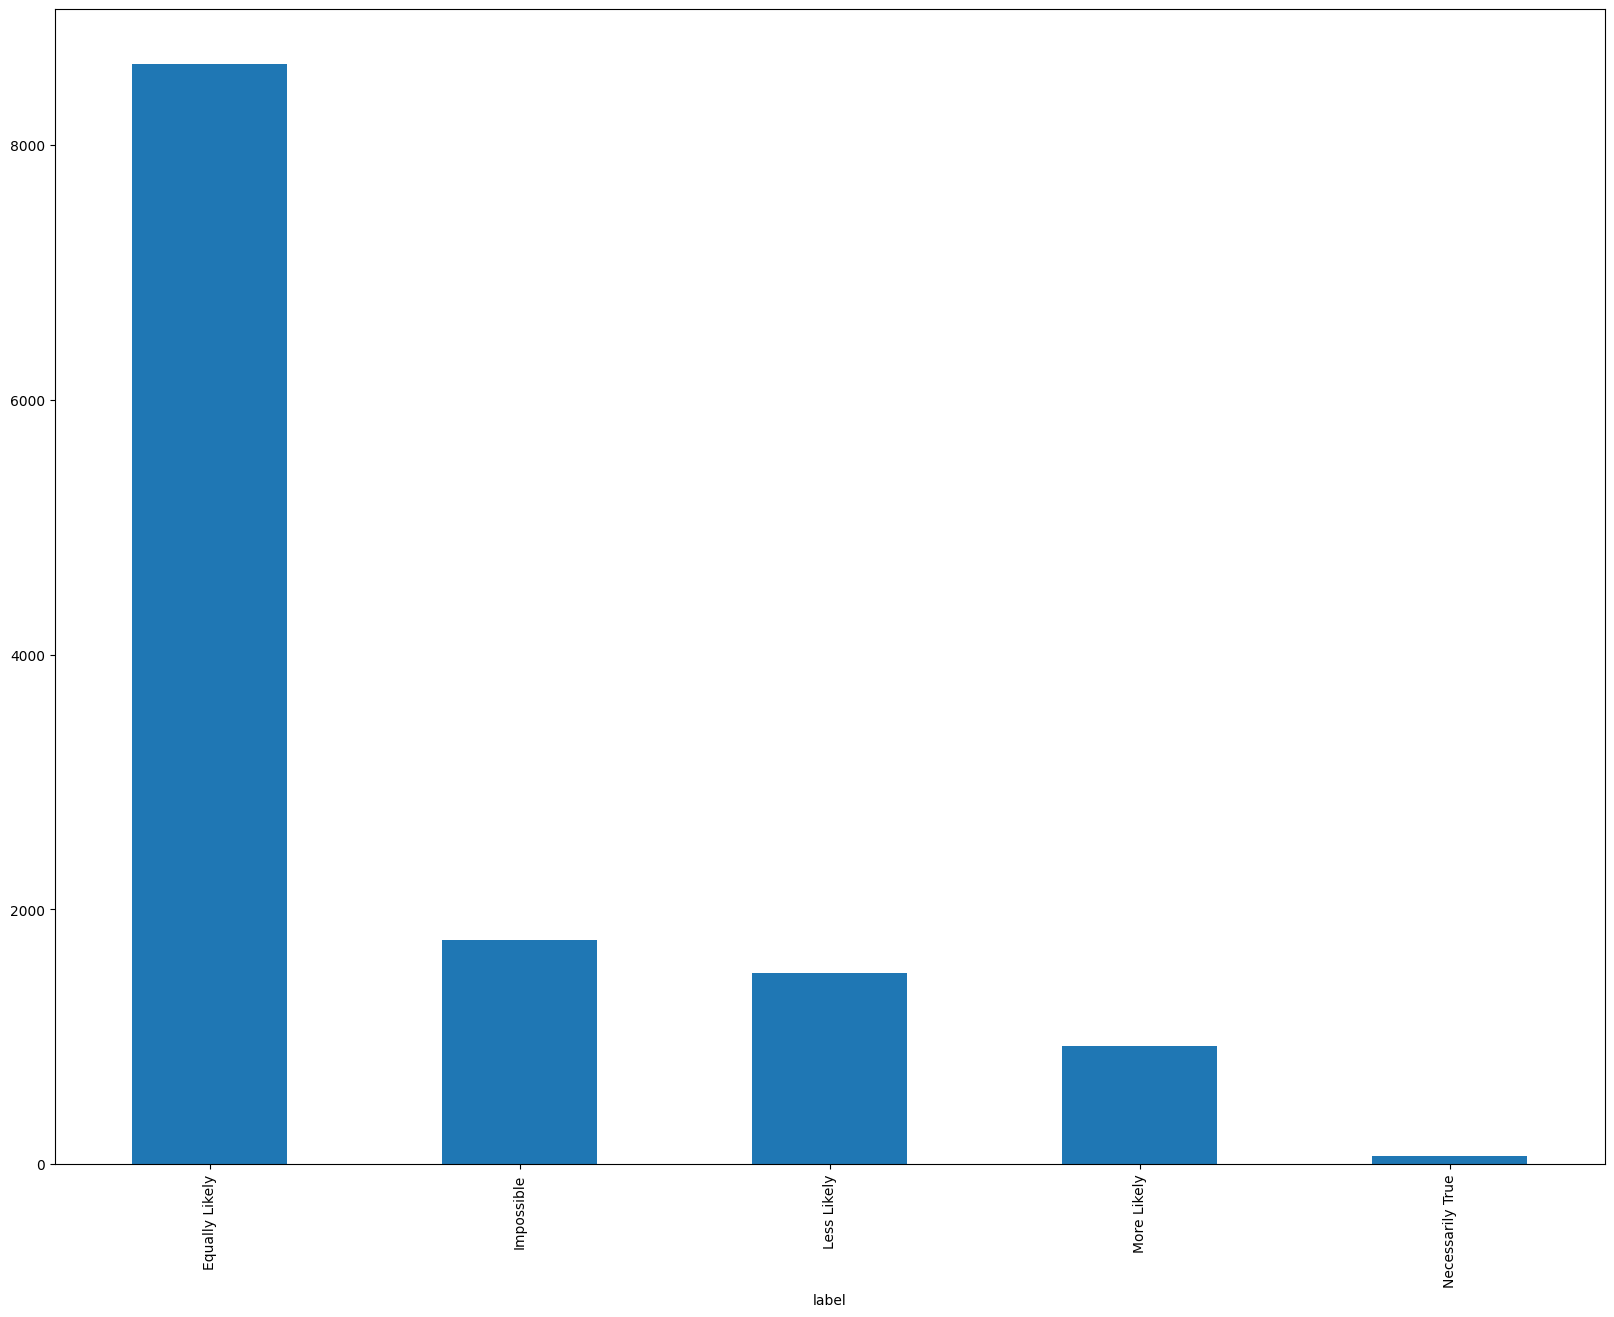

In [219]:
df_train.label.apply(lambda x: label_to_class_map[x]).value_counts().plot(kind="bar")

In [220]:
df_train.shape

(12892, 6)

Labels are as follows:

0->4 in  increasing order of plausiablity

From impossible to necessarily true

## Characterstic 1

#### Here, we can see that the train dataset is imbalanced, there are only 65 data points which falls under the category 5 (label 4) which corrosponds to the label: "necessarily true". Similiarly, we can see that there are less data points for "more likely" event. 

#### To tackle this, in our evaluation metrics, we have to make sure that recall for category 5 is high, so that we know that our model is not biased and classifying all the data points as implausible.

#### Another thing we can do is, we can try to augment the dataset and make more datapoints for the category 5. We'll try that in a later section of this analysis.

Let's look at other characterstics first

In [221]:
for idx, row in df_train.iterrows():
    if "monkey" in row.to_dict()['sentence1']:
        print(row)

sentence1        A monkey is hanging off a tree.
sentence2    A fly monkey is hanging off a tree.
modifier                                     fly
noun                                      monkey
label                                          0
idx                                        12228
Name: 2398, dtype: object
sentence1        A monkey has a nose.
sentence2    A new monkey has a nose.
modifier                          new
noun                           monkey
label                               2
idx                             12265
Name: 2778, dtype: object
sentence1          A monkey wants a banana.
sentence2    A giant monkey wants a banana.
modifier                              giant
noun                                 monkey
label                                     2
idx                                    2239
Name: 9290, dtype: object
sentence1         A monkey turns on a light switch.
sentence2    A dead monkey turns on a light switch.
modifier                        

#### Here, from the result 1 and result 5, we can see that the label represents the likelihood of the sentence 2 (with the modifier before noun)

# Text Statistics

#### Word Count and Token Frequency
#### Let's take the word count of sentence 2 into consideration (word count of sentence 1 will always be 1 less)

In [222]:
from nltk.stem import PorterStemmer

In [223]:
porter_stemmer_object = PorterStemmer()
porter_stemmer_object.stem("disgusted")

'disgust'

In [224]:
total_word_count = 0
word_freq_map = dict()
for idx, row in df_train.iterrows():
    text = row.to_dict()['sentence2']
    words = text.split()
    total_word_count += len(words)
    for word in words:
        # Here, we are normalizing the words by lowercasing and stemming
        word_norm = word.lower()
        word_freq_map[word_norm] = word_freq_map.get(word_norm, 0) + 1

In [225]:
total_word_count

92675

In [226]:
# representing dict in decreasing order of frequency
word_freq_map = dict(sorted(word_freq_map.items(), key=lambda item: item[1], reverse=True))

In [227]:
print(len(word_freq_map.keys()))
list(word_freq_map.items())[:10]

12586


[('a', 10413),
 ('is', 6819),
 ('for', 4431),
 ('to', 2663),
 ('an', 1980),
 ('used', 1690),
 ('you', 1679),
 ('use', 1569),
 ('the', 1390),
 ('of', 917)]

In [228]:
from wordcloud import WordCloud, STOPWORDS

In [244]:
# Code for this wordcloud configuration taken and modified accordingly from the following stackoverflow page
# https://stackoverflow.com/questions/69997140/multiple-wordcloud-plots-with-specific-shape
x, y = np.ogrid[:1200, :1200]
mask = (x - 600) ** 2 + (y - 600) ** 2 > 520 ** 2
mask = 255 * mask.astype(int)

In [230]:
mask.shape

(1200, 1200)

In [231]:
wordcloud = WordCloud(background_color="white", mask=mask, contour_width=0.1, 
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2", width=1600, height=800)

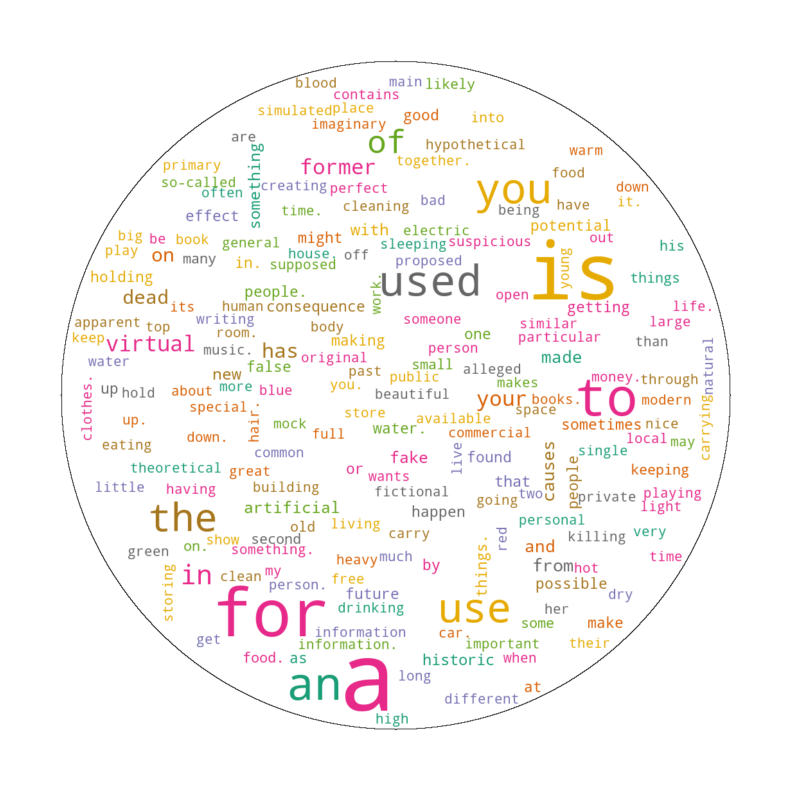

In [245]:
wordcloud.generate_from_frequencies(frequencies=word_freq_map)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Here, we can see there are a lot of stop words, let's try to remove them

In [233]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stopwords like "not" can cause an problem, let's see if we have them in our dataset.

In [234]:
c = 0
for idx, row in df_train.iterrows():
    if " not " in row.to_dict()['sentence1'] and c<3:
        c+= 1
        print(row)

sentence1        Attention is drawn to something not ordinary.
sentence2    Overt attention is drawn to something not ordi...
modifier                                                 overt
noun                                                 attention
label                                                        2
idx                                                      10050
Name: 2552, dtype: object
sentence1           You use a yard to park trucks not in use.
sentence2    You use a marked yard to park trucks not in use.
modifier                                               marked
noun                                                     yard
label                                                       2
idx                                                      4474
Name: 2904, dtype: object
sentence1             Wind is felt but not seen.
sentence2    Vertical wind is felt but not seen.
modifier                                vertical
noun                                        wind
la

Here, we can't remove every stopword as it can cause issues (change in context)

Let's remove the first few frequent words that don't contribute much to the context

In [235]:
unimportant_words = ['a', 'is', 'for', 'to', 'an', 'used', 'you', 'your', 'use', 'the', 'of', 'in', 'very', 'on', 'has', 'from', 'and', "something", "sometimes"]

In [236]:
word_freq_map_updated = dict([(key, value) for (key, value) in word_freq_map.items() if key not in unimportant_words])

In [237]:
list(word_freq_map_updated.items())[:10]

[('virtual', 378),
 ('former', 354),
 ('dead', 307),
 ('causes', 246),
 ('made', 222),
 ('fake', 211),
 ('with', 201),
 ('new', 195),
 ('artificial', 193),
 ('that', 180)]

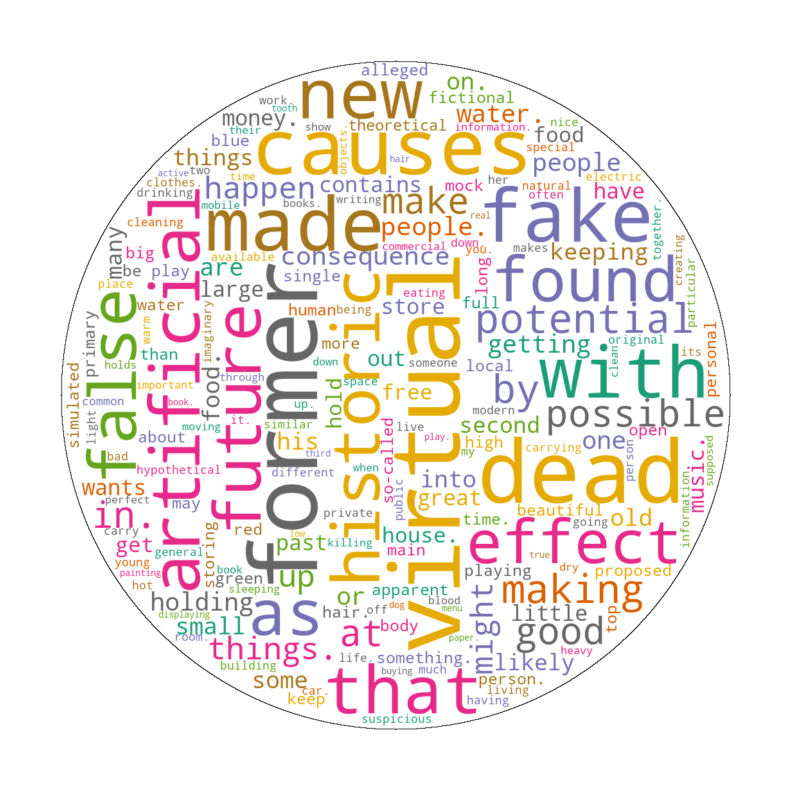

In [238]:
wordcloud.generate_from_frequencies(frequencies=word_freq_map_updated)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Now, we can see the frequent words that explains more context easily

#### Now, let's try to see if there are any frequent words that are in different labels. The motivation behind this is to identify the words that are common between some specific classes in this dataset

In [344]:
class_to_word_freq_map = dict()
class_text_statistics_map = dict()
for idx, row in df_train.iterrows():
    text = row.to_dict()['sentence2']
    class_name = label_to_class_map[row.to_dict()['label']]
    words = text.split()
    # Here, we are normalizing words to lower case and removing unimportant words
    updated_words = [word.lower() for word in words if word.lower() not in unimportant_words]
    for word_norm in updated_words:
        # Calculating word frequency according to classes
        class_specific_text_statistics_map = class_text_statistics_map.get(class_name, dict())
        class_specific_word_freq_map = class_specific_text_statistics_map.get("word_freq_map", dict())
        class_specific_word_freq_map[word_norm] = class_specific_word_freq_map.get(word_norm, 0) + 1
        class_specific_text_statistics_map["word_freq_map"] = class_specific_word_freq_map
    
        # Storing word length to find average word length
        class_specific_text_statistics_map['word_length_list'] = class_specific_text_statistics_map.get('word_length_list', list()) + [len(word_norm)]
    
        # Updating dictionary that stores all the text statistics
        class_text_statistics_map[class_name] = class_specific_text_statistics_map
        
    # Storing length of sentences to find average sentence length
    class_specific_text_statistics_map['sentence_length_list'] = class_specific_text_statistics_map.get('sentence_length_list', list()) + [len(updated_words)]
    
    # Storing words list so that we can explot ngrams
    class_specific_text_statistics_map['words_list'] = class_specific_text_statistics_map.get('words_list', list()) + updated_words
    
    # Updating dictionary that stores all the text statistics
    class_text_statistics_map[class_name] = class_specific_text_statistics_map

In [345]:
class_text_statistics_map.keys()

dict_keys(['More Likely', 'Equally Likely', 'Less Likely', 'Impossible', 'Necessarily True'])

Now, let's try to make the word cloud for these classes

In [346]:
import numpy as np

In [347]:
plt.rcParams['figure.figsize'] = [20, 15]

In [348]:
x, y = np.ogrid[:600, :600]
mask = (x - 300) ** 2 + (y - 300) ** 2 > 260 ** 2
mask = 255 * mask.astype(int)

In [349]:
wordcloud = WordCloud(background_color="white", mask=mask, contour_width=0.1, 
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2", width=1600, height=800)

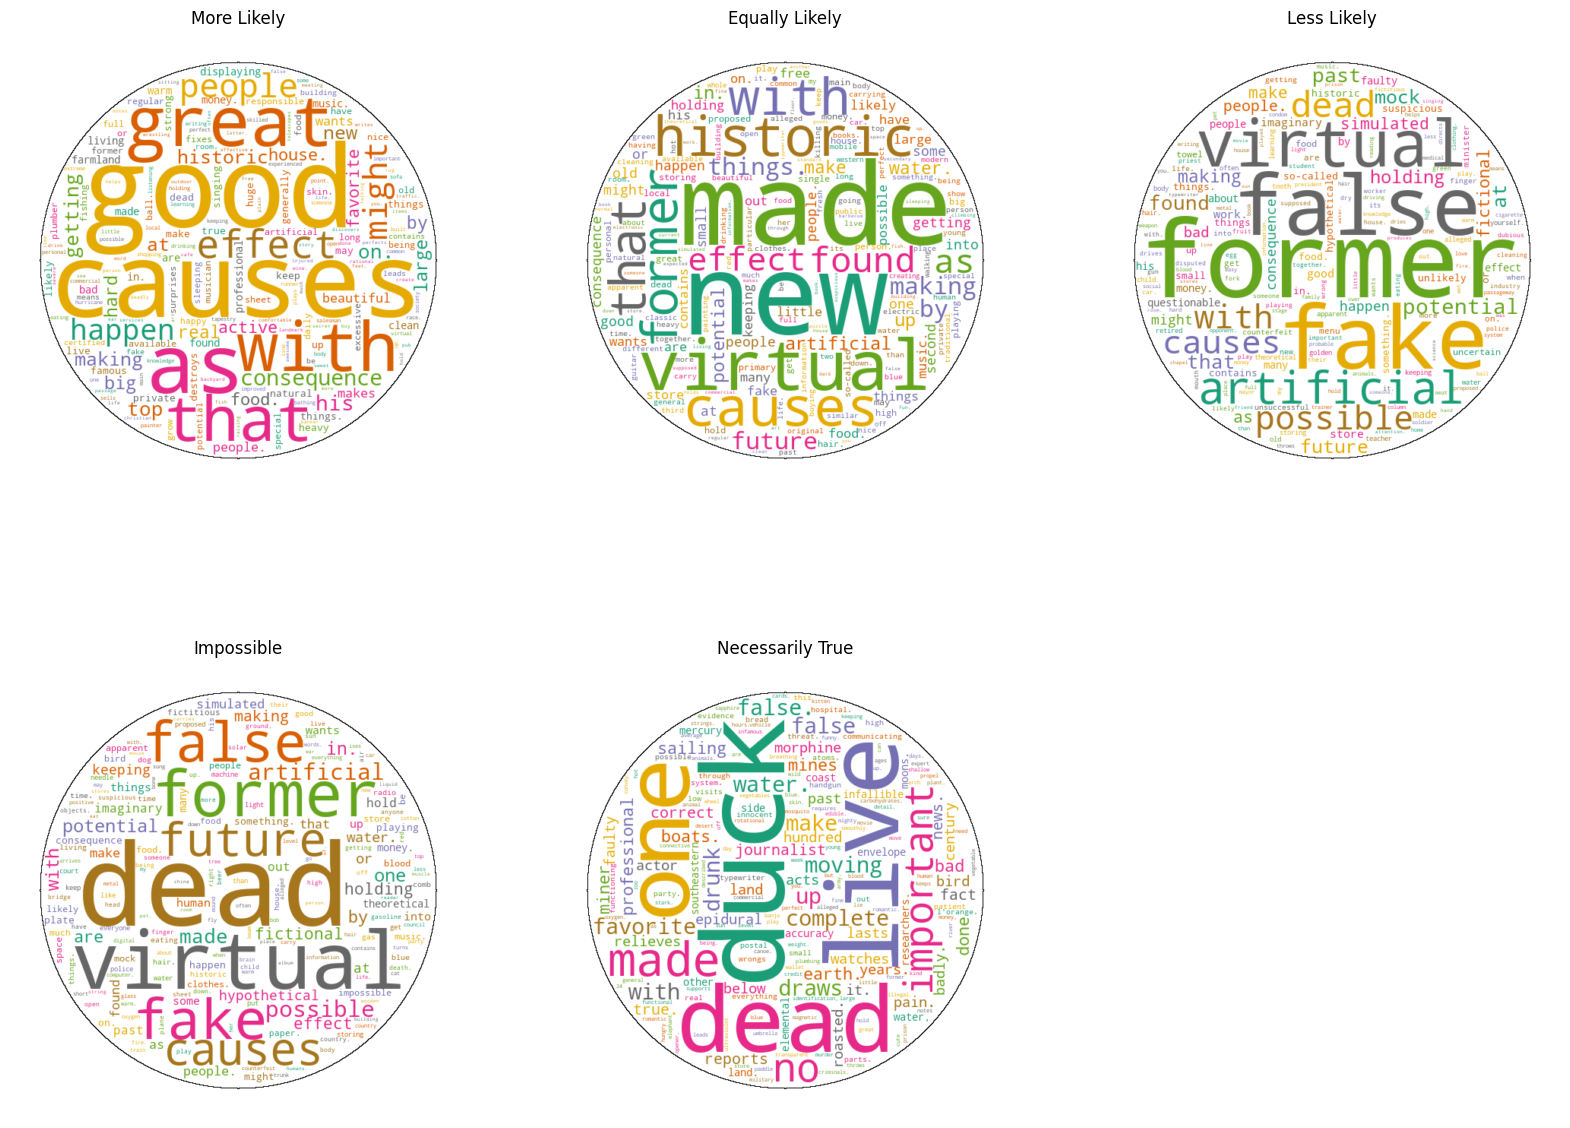

In [350]:
for idx, class_name in enumerate(class_text_statistics_map.keys()):
    wordcloud.generate_from_frequencies(class_text_statistics_map[class_name]['word_freq_map'])   
    plt.subplot(2, 3, idx+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(class_name)
plt.show()

Here, we can clearly see that the word `"dead"` comes more frequently in extreme classes - `Impossible` and `Necessarily True`

I think the reasoning behind it can be that it is adjectives that define the property of a `living` noun and by adding that adjective in front of a noun and clearly classify whether the noun in question is able to interact with other things or not. For example: "A dead monkey jumps from one tree to another"

Another thing that can be noticed here is the word `"fake"` occurs more frequently in the classes - `Impossible` and `Less Likely`

I think the reasoning behind it can be the same as above, except for the fact that fake things can't do much.
The same can be said for the word `"virtual"`, but it also can also come under the context of `"Equally Likely"` cases if we consider the semantic meaning of the words.

We can also see that semantically similary words like `"good"` and `"great"` comes under the same class - `More Likely`

# Characterstic 2 
### Here, we can see that frequency of adjectives in thier respective classes is somewhat proportional to the semantic meaning of the that adjective. We can use this information in preprocessing of our text data and make use of embeddings that take semantic meaning of words/sentences into account.

#### Now, let's take a look at some other text statistics

Class: More Likely | Average Word Length: 6.57 | Average Sentence Length: 7.37
Class: Equally Likely | Average Word Length: 6.47 | Average Sentence Length: 7.53
Class: Less Likely | Average Word Length: 6.39 | Average Sentence Length: 7.47
Class: Impossible | Average Word Length: 6.2 | Average Sentence Length: 7.4
Class: Necessarily True | Average Word Length: 6.07 | Average Sentence Length: 7.17

In [351]:
for idx, class_name in enumerate(class_text_statistics_map.keys()):
    average_word_length = round(np.array(class_text_statistics_map[class_name]["word_length_list"]).mean(), 2)
    average_sentence_length = round(np.array(class_text_statistics_map[class_name]["sentence_length_list"]).mean(), 2)
    print("Class: {} | Average Word Length: {} | Average Sentence Length: {}".format(class_name, average_word_length, average_sentence_length))

Class: More Likely | Average Word Length: 6.57 | Average Sentence Length: 4.44
Class: Equally Likely | Average Word Length: 6.47 | Average Sentence Length: 4.39
Class: Less Likely | Average Word Length: 6.39 | Average Sentence Length: 4.35
Class: Impossible | Average Word Length: 6.2 | Average Sentence Length: 4.41
Class: Necessarily True | Average Word Length: 6.07 | Average Sentence Length: 4.52


#### Here, we can see that the average word length in extreme case classes `Impossible` and `Necessarily True` are a little bit shorter than other classes. The difference is not too big though.
#### For average sentence length, the values are really close, so can't get much insight from them.

#### Now, let's look at bigram wordclouds

In [355]:
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download('punkt')
# nltk.download('wordnet')

In [356]:
def generate_bigrams_freq_map_from_text(words_list):
    # this function is generated using answer (we modified it according to our need) from stackoverflow from the link below 
    # https://stackoverflow.com/questions/49537474/wordcloud-of-bigram-using-python
    bigrams_list = list(nltk.bigrams(words_list))
    dictionary2 = [' '.join(tup) for tup in bigrams_list]
    
    #Using count vectoriser to view the frequency of bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary2)
    # vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    words_dict = dict(words_freq)
    return words_dict

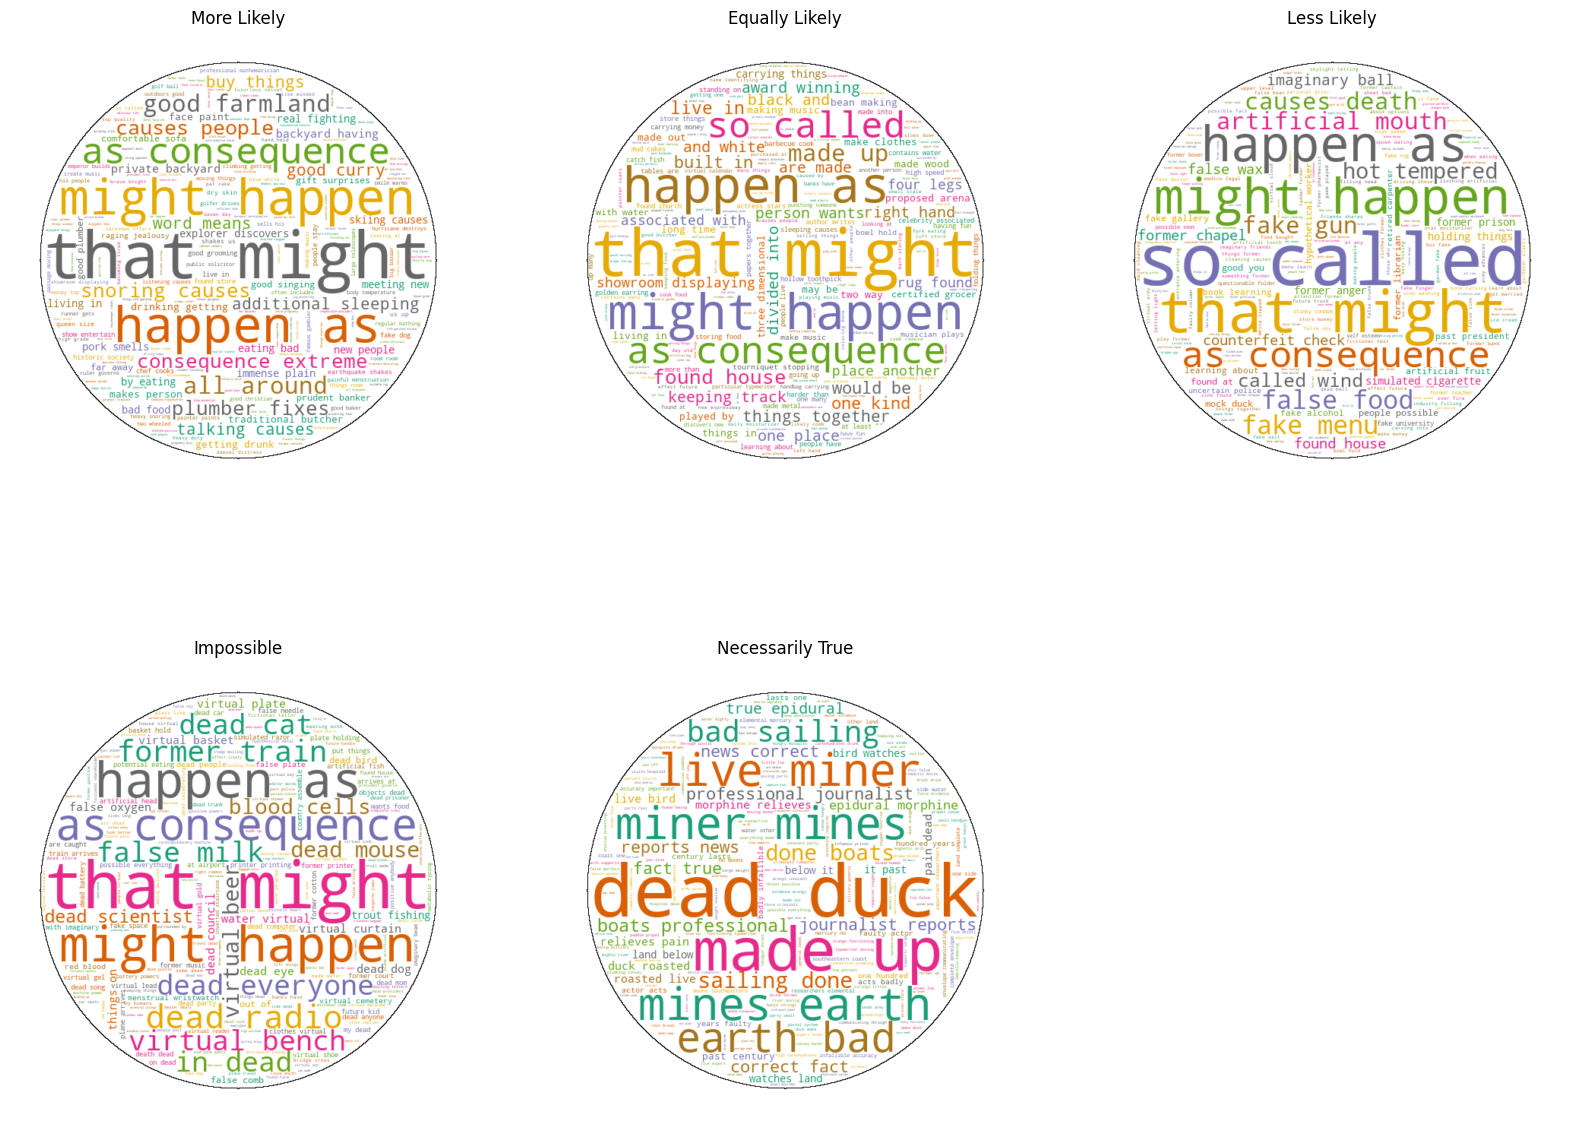

In [358]:
for idx, class_name in enumerate(class_text_statistics_map.keys()):
    class_word_list = class_text_statistics_map[class_name]["words_list"]
    bigrams_freq_map = generate_bigrams_freq_map_from_text(class_word_list)
    wordcloud.generate_from_frequencies(bigrams_freq_map)   
    plt.subplot(2, 3, idx+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(class_name)
plt.show()